In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import scipy.sparse as sparse
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from sklearn.metrics import roc_auc_score, f1_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from catboost import CatBoostClassifier
from pandas_profiling import ProfileReport

%matplotlib inline

/Users/maksim/opt/anaconda3/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


## Data loading

In [2]:
train = pd.read_csv('train.csv', low_memory=False)
test = pd.read_csv('test.csv', low_memory=False)
submission = pd.read_csv('sample_submission.csv', low_memory=False)

In [3]:
train_data, test_data = train_test_split(train, test_size=0.2, shuffle=True, random_state=42)

In [4]:
# train_data = train
# test_data = test

## Simple features-free modeling with LightFM

In [5]:
ratings_coo = sparse.coo_matrix((train_data.rating.astype(int), 
                                 (train_data.userid, train_data.itemid)))

In [6]:
# lr_list = [0.11, 0.12, 0.13, 0.15, 0.17, 0.2, 0.25, 0.3]
# comp_list = [10, 15, 20, 25, 30, 50, 100, 150, 300]

lr_list = [0.17]
comp_list = [105, 150, 200]

score_list = []
params = []

In [7]:
for lr in tqdm(lr_list):
    for comp in comp_list:
        for ep in [10, 11]:
            model = LightFM(learning_rate=lr, loss='logistic', no_components=comp, 
                            learning_schedule='adagrad', random_state=42)
            model = model.fit(ratings_coo, epochs=ep, num_threads=8)
            preds = model.predict(test_data.userid.values, test_data.itemid.values)
            preds_norm = ((preds-preds.min()) / (preds-preds.min()).max())
            roc_auc = roc_auc_score(test_data.rating.values, preds_norm)
            params.append([lr, comp])
            score_list.append(roc_auc)
            print(f'epochs = {ep}')
            print(f'lr = {lr}, comp = {comp}')
            print(f'roc_auc_score = {roc_auc}')
            print('######################################################')
        
max_idx = np.argmax(np.array(score_list))
print()
print(f'epoch = {ep}')
print(score_list[max_idx])
print(params[max_idx])

  0%|          | 0/1 [00:00<?, ?it/s]

epochs = 10
lr = 0.17, comp = 105
roc_auc_score = 0.7595045154621247
######################################################
epochs = 11
lr = 0.17, comp = 105
roc_auc_score = 0.7589434460034084
######################################################
epochs = 10
lr = 0.17, comp = 150
roc_auc_score = 0.7596613539035579
######################################################
epochs = 11
lr = 0.17, comp = 150
roc_auc_score = 0.7593544627248463
######################################################
epochs = 10
lr = 0.17, comp = 200
roc_auc_score = 0.7595644850620639
######################################################


100%|██████████| 1/1 [02:59<00:00, 179.62s/it]

epochs = 11
lr = 0.17, comp = 200
roc_auc_score = 0.7591781405139923
######################################################

epoch = 11
0.7596613539035579
[0.17, 150]


## Catsboost classifier as recommender

### Data analysis and cleaning

In [8]:
with open('meta_Grocery_and_Gourmet_Food.json', 'rb') as file:
    meta_list = []
    for line in file.readlines():
        meta_list.append(json.loads(line))

In [9]:
meta = pd.DataFrame(meta_list)

In [10]:
train_full = pd.merge(train, meta, on='asin')

In [11]:
columns_to_drop = [
    'reviewTime',
    'reviewerName',
    'style',
    'image_x',
    'image_y',
    'date',
    'feature',
    'details',
    'tech1',
    'fit', 
    'similar_item', 
    'vote']

In [64]:
def clean_data(input_data):
    data = input_data.drop(columns_to_drop, axis=1)
    
    data.summary.fillna('Nothing', inplace=True)
    data.brand.fillna('No brand', inplace=True)
    data.description.fillna('No description', inplace=True)
    data['reviewText'].fillna('No review', inplace=True)
    data['main_cat'].fillna(data_sample.main_cat.mode()[0], inplace=True)
    
    # from list of categoryies to additional columns
    cat_df = pd.DataFrame(data.category.values.tolist(), 
                          index=data.index, dtype=str).add_prefix('category_')
    cat_df.fillna('No category', inplace=True)
    data = pd.concat([data, cat_df.iloc[:, :4]], axis=1)
    
    # join all descriptions in the list
    data['description'] = data.description.map(lambda x: ' '.join(x))
    
    # fix the price
    data['price'] = data.price.str.findall(r'\d+\.\d+').apply(lambda x: 
                                                              x if type(x)!=list else x[0]).astype('float64')
    data.price.fillna(data.groupby('main_cat').price.mean())
    data['price'] = np.log(data['price']+1)
    
    # also_view/buy features - put the count of viewed/bought items
    data['also_view'] = data.also_view.apply(lambda x: np.nan if type(x)!=list else len(x))
    data['also_buy'] = data.also_buy.apply(lambda x: np.nan if type(x)!=list else len(x))
    data['also_view'].fillna(data.groupby('userid')['also_view'].median(), inplace=True)
    data['also_buy'].fillna(data.groupby('userid')['also_buy'].median(), inplace=True)
#     data['also_view'] = np.log(data['also_view']+1)
#     data['also_buy'] = np.log(data['also_buy']+1)
    
    # verified
    data['verified'] = data.verified.map({True:1, False:0})
    
    # rank
    data['rank'] = data['rank'].str.findall('\d+,+\d+').map(lambda x: float(x[0].replace(',', '.')) 
                                                            if ((type(x)==list)
                                                            and (len(x)!=0)) else np.nan)
    data['rank'].fillna(data.groupby('main_cat')['rank'].mean(), inplace=True)
    data['rank'] = np.log(data['rank']+1)
    
    # log overall
#     data['overall'] = np.log(data['overall']+1)
    
    # delete bad features and target
    data.drop('category', axis=1, inplace=True)
    data.drop('category_0', axis=1, inplace=True)
    
    return data

In [65]:
sample = train_full.sample(frac=0.3)

In [66]:
data_sample = clean_data(sample)

In [67]:
profile = ProfileReport(df=data_sample, title='EDA')

In [68]:
profile.to_notebook_iframe()

### Data splitting

In [70]:
num_features = ['unixReviewTime', 'price', 'rank', 'also_view', 'also_buy',]
cat_features = ['verified', 'asin', 'userid', 'itemid', 'brand', 'main_cat', 
                'category_1', 'category_2', 'category_3']
text_features = ['reviewText', 'summary', 'title',]# 'description']

target_features = ['overall', 'rating']

In [71]:
X, y = data_sample.drop(target_features, axis=1), data_sample.rating

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, shuffle=True, random_state=42)

### Custom "mean" encoding

In [73]:
def make_rating_mean_count(df_mean_train, df_mean_test, col, df_train, df_test, group_cols=None):
    
    # функция добавляет в df_mean_train и df_mean_test столбцы средней цены/количества объявлений
    # для каждого категориального признака col. group_cols - лист с дополнительными признаками,
    # которые позволяют группировать рейтинг/количества по связке "признаки group_cols + признак col"
    
    join_cols = []
    
    if (group_cols!=None) and (col not in group_cols):
        join_cols.append(col) 
        join_cols += group_cols
    else:
        join_cols.append(col)
    df_mean_train[col+'_rating_mean'] = df_train[join_cols].merge(df_train.groupby(by=join_cols, as_index=False).
                                                                 rating.median(), on=join_cols, how='left').iloc[:,-1]
    df_mean_test[col+'_rating_mean'] = df_test[join_cols].merge(df_train.groupby(by=join_cols, as_index=False).
                                                               rating.median(), on=join_cols, how='left').iloc[:,-1]
    df_mean_train[col+'_count'] = df_train[join_cols].merge(df_train.groupby(by=join_cols, as_index=False).
                                                            rating.count(), on=join_cols, how='left').iloc[:,-1]
    df_mean_test[col+'_count'] = df_test[join_cols].merge(df_train.groupby(by=join_cols, as_index=False).
                                                          rating.count(), on=join_cols, how='left').iloc[:,-1]   
    
    if col == 'model': 
        df_mean_test[col+'_rating_mean'] = df_mean_test[col+'_rating_mean'].\
        fillna(df_mean_test['brand_rating_mean']) 
        
        df_mean_test[col+'_count'] = df_mean_test[col+'_count'].\
        fillna(df_mean_test['brand_count'])
    
    if col == 'model_name':
        df_mean_test[col+'_rating_mean'] = df_mean_test[col+'_rating_mean'].\
        fillna(df_mean_test['model_rating_mean']).\
        fillna(df_mean_test['brand_rating_mean'])    
        
        df_mean_test[col+'_count'] = df_mean_test[col+'_count'].\
        fillna(df_mean_test['model_count']).\
        fillna(df_mean_test['brand_count'])  
    
    if col == 'modification':
        df_mean_test[col+'_rating_mean'] = df_mean_test[col+'_rating_mean'].\
        fillna(df_mean_test['model_name_rating_mean']).fillna(df_mean_test['model_rating_mean']).\
        fillna(df_mean_test['brand_rating_mean'])    
        
        df_mean_test[col+'_count'] = df_mean_test[col+'_count'].\
        fillna(df_mean_test['model_name_count']).fillna(df_mean_test['model_count']).\
        fillna(df_mean_test['brand_count'])
        
        
    other_filler_rating_mean = df_mean_test[f'{col}_rating_mean'].median()
    df_mean_test[f'{col}_rating_mean'] = df_mean_test[f'{col}_rating_mean'].fillna(other_filler_rating_mean)

    other_filler_count = df_mean_test[f'{col}_count'].median()
    df_mean_test[f'{col}_count'] = df_mean_test[f'{col}_count'].fillna(other_filler_count)



def make_num_feat_mean(df_mean_train, df_mean_test, col, num_col, df_train, df_test, group_cols=None):
    
    # аналогичная функция, но кодирует категориальные признаки по средним значениям числовых колонок (num_features)
    
    if col in ['itemid', 'userid']:
        join_cols = []

        if (group_cols!=None) and (col not in group_cols):
            join_cols.append(col) 
            join_cols += group_cols
        else:
            join_cols.append(col)

        df_mean_train[f'{col}_{num_col}_mean'] = df_train[join_cols].merge(df_train.groupby(by=join_cols, as_index=False)\
                                                               [num_col].mean(), on=join_cols, how='left').iloc[:,-1]

        df_mean_test[f'{col}_{num_col}_mean'] = df_test[join_cols].merge(df_train.groupby(by=join_cols, as_index=False)\
                                                               [num_col].mean(), on=join_cols, how='left').iloc[:,-1]

        if col == 'model': 
            df_mean_test[f'{col}_{num_col}_mean'] = df_mean_test[f'{col}_{num_col}_mean'].\
            fillna(df_mean_test[f'brand_{num_col}_mean']) 

        if col == 'model_name':
            df_mean_test[f'{col}_{num_col}_mean'] = df_mean_test[f'{col}_{num_col}_mean'].\
            fillna(df_mean_test[f'model_{num_col}_mean']).\
            fillna(df_mean_test[f'brand_{num_col}_mean'])    

        if col == 'modification':
            df_mean_test[f'{col}_{num_col}_mean'] = df_mean_test[f'{col}_{num_col}_mean'].\
            fillna(df_mean_test[f'model_name_{num_col}_mean']).fillna(df_mean_test[f'model_{num_col}_mean']).\
            fillna(df_mean_test[f'brand_{num_col}_mean'])    

        other_filler = df_mean_test[f'{col}_{num_col}_mean'].median()
        df_mean_test[f'{col}_{num_col}_mean'] = df_mean_test[f'{col}_{num_col}_mean'].fillna(other_filler)



In [74]:
# получаем индексы train и test выборок
train_idx = y_train.index.values
test_idx = y_test.index.values

# добавляем таргет и получаем 2 выборки "признак=таргет"
df_train = data_sample.loc[train_idx]
df_test = data_sample.loc[test_idx]

# пустые фреймы для mean/count encoding features
df_mean_train = pd.DataFrame(index=train_idx)
df_mean_test = pd.DataFrame(index=test_idx)

# создаем кодированные категориальные признаки
for col in cat_features:
    make_rating_mean_count(df_mean_train, df_mean_test, col, df_train, df_test, group_cols=None)
    for num_col in num_features:
        make_num_feat_mean(df_mean_train, df_mean_test, col, num_col, df_train, df_test, group_cols=None)
        
mean_columns = df_mean_test.columns

X_train_cat = np.array(df_mean_train)
X_test_cat = np.array(df_mean_test)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

### Vectorizing text features

In [75]:
vectorizer = TfidfVectorizer(stop_words='english', analyzer='word')

In [96]:
i = 0
for col in text_features:
    if i==0:
        X_train_text = vectorizer.fit_transform(X_train[col])
        X_test_text = vectorizer.transform(X_test[col])
        text_fi_cols = vectorizer.get_feature_names()
        continue
    X_train_text = sparse.hstack([X_train_text, vectorizer.fit_transform(X_train[col])])
    X_test_text = sparse.hstack([X_test_text, vectorizer.transform(X_test[col])])
    text_fi_cols += vectorizer.get_feature_names()

In [98]:
X_train_final = sparse.hstack([X_train[num_features], X_train_cat, X_train_text])
X_test_final = sparse.hstack([X_test[num_features], X_test_cat, X_test_text])

## Modelling with CatboostClassifier

In [99]:
estimator = CatBoostClassifier(depth=7, iterations=1000, learning_rate=0.1, verbose=True, random_state=42)

In [100]:
estimator.fit(X_train_final, y_train)

0:	learn: 0.6359819	total: 182ms	remaining: 3m 2s
1:	learn: 0.5909022	total: 1.11s	remaining: 9m 14s
2:	learn: 0.5554352	total: 1.65s	remaining: 9m 9s
3:	learn: 0.5275463	total: 2s	remaining: 8m 16s
4:	learn: 0.5055351	total: 2.5s	remaining: 8m 17s
5:	learn: 0.4882313	total: 2.97s	remaining: 8m 12s
6:	learn: 0.4745710	total: 3.44s	remaining: 8m 8s
7:	learn: 0.4637249	total: 3.91s	remaining: 8m 4s
8:	learn: 0.4551943	total: 4.37s	remaining: 8m 1s
9:	learn: 0.4484043	total: 4.83s	remaining: 7m 58s
10:	learn: 0.4430276	total: 5.3s	remaining: 7m 56s
11:	learn: 0.4387294	total: 5.77s	remaining: 7m 55s
12:	learn: 0.4353205	total: 6.24s	remaining: 7m 53s
13:	learn: 0.4324996	total: 6.73s	remaining: 7m 53s
14:	learn: 0.4301308	total: 7.25s	remaining: 7m 56s
15:	learn: 0.4281616	total: 7.81s	remaining: 8m
16:	learn: 0.4267697	total: 8.26s	remaining: 7m 57s
17:	learn: 0.4254479	total: 8.81s	remaining: 8m
18:	learn: 0.4243693	total: 9.46s	remaining: 8m 8s
19:	learn: 0.4235382	total: 10.2s	remaini

158:	learn: 0.4097623	total: 1m 17s	remaining: 6m 51s
159:	learn: 0.4096938	total: 1m 18s	remaining: 6m 50s
160:	learn: 0.4096515	total: 1m 18s	remaining: 6m 50s
161:	learn: 0.4095868	total: 1m 19s	remaining: 6m 49s
162:	learn: 0.4095100	total: 1m 19s	remaining: 6m 49s
163:	learn: 0.4094756	total: 1m 20s	remaining: 6m 48s
164:	learn: 0.4094147	total: 1m 20s	remaining: 6m 47s
165:	learn: 0.4093841	total: 1m 21s	remaining: 6m 47s
166:	learn: 0.4093287	total: 1m 21s	remaining: 6m 46s
167:	learn: 0.4092611	total: 1m 21s	remaining: 6m 45s
168:	learn: 0.4091690	total: 1m 22s	remaining: 6m 45s
169:	learn: 0.4091069	total: 1m 22s	remaining: 6m 44s
170:	learn: 0.4090518	total: 1m 23s	remaining: 6m 44s
171:	learn: 0.4089856	total: 1m 23s	remaining: 6m 43s
172:	learn: 0.4089130	total: 1m 24s	remaining: 6m 43s
173:	learn: 0.4088633	total: 1m 24s	remaining: 6m 42s
174:	learn: 0.4088069	total: 1m 25s	remaining: 6m 41s
175:	learn: 0.4087194	total: 1m 25s	remaining: 6m 41s
176:	learn: 0.4086646	total:

311:	learn: 0.4030270	total: 2m 29s	remaining: 5m 28s
312:	learn: 0.4029949	total: 2m 29s	remaining: 5m 28s
313:	learn: 0.4029511	total: 2m 29s	remaining: 5m 27s
314:	learn: 0.4029279	total: 2m 30s	remaining: 5m 26s
315:	learn: 0.4028857	total: 2m 30s	remaining: 5m 26s
316:	learn: 0.4028383	total: 2m 31s	remaining: 5m 25s
317:	learn: 0.4028237	total: 2m 31s	remaining: 5m 25s
318:	learn: 0.4028024	total: 2m 32s	remaining: 5m 24s
319:	learn: 0.4027885	total: 2m 32s	remaining: 5m 24s
320:	learn: 0.4027507	total: 2m 32s	remaining: 5m 23s
321:	learn: 0.4027288	total: 2m 33s	remaining: 5m 23s
322:	learn: 0.4027028	total: 2m 33s	remaining: 5m 22s
323:	learn: 0.4026900	total: 2m 34s	remaining: 5m 21s
324:	learn: 0.4026456	total: 2m 34s	remaining: 5m 21s
325:	learn: 0.4026144	total: 2m 35s	remaining: 5m 20s
326:	learn: 0.4025334	total: 2m 35s	remaining: 5m 20s
327:	learn: 0.4024880	total: 2m 36s	remaining: 5m 19s
328:	learn: 0.4024771	total: 2m 36s	remaining: 5m 19s
329:	learn: 0.4024281	total:

464:	learn: 0.3981197	total: 3m 41s	remaining: 4m 14s
465:	learn: 0.3981080	total: 3m 41s	remaining: 4m 13s
466:	learn: 0.3980985	total: 3m 41s	remaining: 4m 13s
467:	learn: 0.3980603	total: 3m 42s	remaining: 4m 12s
468:	learn: 0.3980255	total: 3m 43s	remaining: 4m 12s
469:	learn: 0.3979932	total: 3m 43s	remaining: 4m 12s
470:	learn: 0.3979832	total: 3m 44s	remaining: 4m 11s
471:	learn: 0.3979715	total: 3m 44s	remaining: 4m 11s
472:	learn: 0.3979272	total: 3m 44s	remaining: 4m 10s
473:	learn: 0.3978826	total: 3m 45s	remaining: 4m 10s
474:	learn: 0.3978724	total: 3m 45s	remaining: 4m 9s
475:	learn: 0.3978626	total: 3m 46s	remaining: 4m 9s
476:	learn: 0.3978272	total: 3m 46s	remaining: 4m 8s
477:	learn: 0.3977944	total: 3m 47s	remaining: 4m 8s
478:	learn: 0.3977818	total: 3m 47s	remaining: 4m 7s
479:	learn: 0.3977684	total: 3m 48s	remaining: 4m 7s
480:	learn: 0.3977575	total: 3m 48s	remaining: 4m 7s
481:	learn: 0.3977161	total: 3m 49s	remaining: 4m 6s
482:	learn: 0.3977083	total: 3m 49s	

617:	learn: 0.3942288	total: 4m 58s	remaining: 3m 4s
618:	learn: 0.3942115	total: 4m 59s	remaining: 3m 4s
619:	learn: 0.3941911	total: 4m 59s	remaining: 3m 3s
620:	learn: 0.3941803	total: 5m	remaining: 3m 3s
621:	learn: 0.3941463	total: 5m 1s	remaining: 3m 3s
622:	learn: 0.3940864	total: 5m 1s	remaining: 3m 2s
623:	learn: 0.3940407	total: 5m 2s	remaining: 3m 2s
624:	learn: 0.3940078	total: 5m 2s	remaining: 3m 1s
625:	learn: 0.3939952	total: 5m 3s	remaining: 3m 1s
626:	learn: 0.3939422	total: 5m 3s	remaining: 3m
627:	learn: 0.3939305	total: 5m 4s	remaining: 3m
628:	learn: 0.3938908	total: 5m 4s	remaining: 2m 59s
629:	learn: 0.3938783	total: 5m 5s	remaining: 2m 59s
630:	learn: 0.3938647	total: 5m 5s	remaining: 2m 58s
631:	learn: 0.3938398	total: 5m 6s	remaining: 2m 58s
632:	learn: 0.3937950	total: 5m 6s	remaining: 2m 57s
633:	learn: 0.3937740	total: 5m 7s	remaining: 2m 57s
634:	learn: 0.3937351	total: 5m 8s	remaining: 2m 57s
635:	learn: 0.3937220	total: 5m 8s	remaining: 2m 56s
636:	learn

771:	learn: 0.3901859	total: 6m 22s	remaining: 1m 52s
772:	learn: 0.3901517	total: 6m 23s	remaining: 1m 52s
773:	learn: 0.3901154	total: 6m 23s	remaining: 1m 52s
774:	learn: 0.3901021	total: 6m 24s	remaining: 1m 51s
775:	learn: 0.3900932	total: 6m 24s	remaining: 1m 51s
776:	learn: 0.3900564	total: 6m 25s	remaining: 1m 50s
777:	learn: 0.3900374	total: 6m 25s	remaining: 1m 50s
778:	learn: 0.3900121	total: 6m 26s	remaining: 1m 49s
779:	learn: 0.3899852	total: 6m 26s	remaining: 1m 49s
780:	learn: 0.3899707	total: 6m 27s	remaining: 1m 48s
781:	learn: 0.3899606	total: 6m 27s	remaining: 1m 48s
782:	learn: 0.3899309	total: 6m 28s	remaining: 1m 47s
783:	learn: 0.3898882	total: 6m 29s	remaining: 1m 47s
784:	learn: 0.3898791	total: 6m 29s	remaining: 1m 46s
785:	learn: 0.3898446	total: 6m 30s	remaining: 1m 46s
786:	learn: 0.3897974	total: 6m 30s	remaining: 1m 45s
787:	learn: 0.3897632	total: 6m 31s	remaining: 1m 45s
788:	learn: 0.3897385	total: 6m 32s	remaining: 1m 44s
789:	learn: 0.3897131	total:

925:	learn: 0.3862303	total: 7m 43s	remaining: 37.1s
926:	learn: 0.3862038	total: 7m 44s	remaining: 36.6s
927:	learn: 0.3861625	total: 7m 44s	remaining: 36.1s
928:	learn: 0.3861336	total: 7m 45s	remaining: 35.6s
929:	learn: 0.3861168	total: 7m 45s	remaining: 35.1s
930:	learn: 0.3860860	total: 7m 46s	remaining: 34.6s
931:	learn: 0.3860488	total: 7m 47s	remaining: 34.1s
932:	learn: 0.3860327	total: 7m 47s	remaining: 33.6s
933:	learn: 0.3860084	total: 7m 48s	remaining: 33.1s
934:	learn: 0.3859868	total: 7m 48s	remaining: 32.6s
935:	learn: 0.3859565	total: 7m 49s	remaining: 32.1s
936:	learn: 0.3859276	total: 7m 49s	remaining: 31.6s
937:	learn: 0.3858981	total: 7m 50s	remaining: 31.1s
938:	learn: 0.3858836	total: 7m 51s	remaining: 30.6s
939:	learn: 0.3858468	total: 7m 51s	remaining: 30.1s
940:	learn: 0.3858104	total: 7m 52s	remaining: 29.6s
941:	learn: 0.3857624	total: 7m 52s	remaining: 29.1s
942:	learn: 0.3857547	total: 7m 53s	remaining: 28.6s
943:	learn: 0.3857279	total: 7m 53s	remaining:

In [101]:
y_pred = estimator.predict_proba(X_test_final)

In [102]:
y_pred_1 = estimator.predict(X_test_final)

In [103]:
ras = roc_auc_score(y_test.values, y_pred[:,1])

In [104]:
ras

0.6115741446329063

In [105]:
f1_score(y_test.values, y_pred_1)

0.9166884268103295

In [93]:
fpr, tpr, thresholds = roc_curve(y_test.values, y_pred[:,1])

<AxesSubplot:>

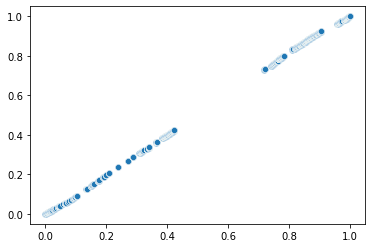

In [94]:
sns.scatterplot(x=fpr, y=tpr)

In [86]:
### Post-modelling analysis

In [ ]:
# fi_cols = num_features + mean_columns.tolist() + text_fi_cols

In [ ]:
# fi_df = pd.DataFrame(zip(estimator.feature_importances_, fi_cols), columns=['importance', 'name'])

In [ ]:
# fi_df.sort_values(by='importance', ascending=False).head(50)

In [ ]:
# rebuilt_data['sqerror'] = (rebuilt_data.rating - rebuilt_data.pred)**2

In [ ]:
# cols = num_features + cat_features + text_features

In [ ]:
# rebuilt_data.columns

In [ ]:
# rebuilt_data.groupby(['main_cat']).sqerror.agg(['mean', 'count']).\
# sort_values(by=['mean'],ascending=False).head(50)

In [ ]:
# f1_score(y_test.values, y_pred_1)

## LightFM with item/user features as recommender

### Prepare LightFM с item/user features

Using cleaned original features

In [107]:
features_user = X_train[['verified', 'userid', 'also_view', 'main_cat', 'also_buy']]
features_item = X_train[['itemid', 'brand', 'rank', 
                             'main_cat', 'price', 'category_1', 'category_2', 'category_3']]

df = pd.concat([X_train[['userid', 'itemid',]], y_train], axis=1)
df_test = pd.concat([X_test[['userid', 'itemid',]], y_test], axis=1)

Custom 'mean' encoded features (commented - too long modeling, more than 2 hours)

In [ ]:
# features_user = pd.concat([df_mean_train[['verified_rating_mean', 'verified_count',
#                                          'userid_rating_mean', 'userid_count', 
#                                          'userid_unixReviewTime_mean', 'userid_price_mean', 
#                                          'userid_rank_mean', 
#                                          'userid_also_view_mean', 'userid_also_buy_mean']], 
#                            X_train['userid']], axis=1)

# features_item = pd.concat([df_mean_train[['asin_rating_mean', 'asin_count', 'itemid_rating_mean','itemid_count', 
#                                           'itemid_unixReviewTime_mean', 'itemid_price_mean', 
#                                           'itemid_rank_mean', 'itemid_also_view_mean',
#                                           'itemid_also_buy_mean']], 
#                            X_train['itemid']], axis=1)

# df = pd.concat([X_train[['userid', 'itemid']], y_train], axis=1)
# df_test = pd.concat([X_test[['userid', 'itemid']], y_test], axis=1)

Creating interaction matrix

In [108]:
item_f = []
col = []
unique_f1 = []
for column in features_item.drop(['itemid'], axis=1):
    col += [column]*len(features_item[column].unique())
    unique_f1 += list(features_item[column].unique())
for x,y in zip(col, unique_f1):
    res = str(x)+ ":" +str(y)
    item_f.append(res)
    
user_f = []
col = []
unique_f1 = []
for column in features_user.drop(['userid'], axis=1):
    col += [column]*len(features_user[column].unique())
    unique_f1 += list(features_user[column].unique())
for x,y in zip(col, unique_f1):
    res = str(x)+ ":" +str(y)
    user_f.append(res)

In [109]:
from lightfm.data import Dataset
# we call fit to supply userid, item id and user/item features
dataset = Dataset()
dataset.fit(
        data_sample['userid'].unique(), # all the users
        data_sample['itemid'].unique(), # all the items
        user_features = user_f,
        item_features = item_f
)

In [110]:
(interactions, weights) = dataset.build_interactions([(x[0], x[1], x[2]) for x in df.values ])

In [111]:
(interactions_test, weights_test) = dataset.build_interactions([(x[0], x[1], x[2]) for x in df_test.values ])

### Generate item_features

In [112]:
temp_list = []
for column in features_item.drop(['itemid'], axis=1):
    temp_list.append(column + ':')

In [113]:
def transform_to_list(row):
    
    result = []
    temp_row = row
    for x,y in zip(temp_list, temp_row):
        res = str(x) +""+ str(y)
        result.append(res)
    return result

In [114]:
subset = features_item.drop(['itemid'], axis=1)
ad_list = [x.tolist() for x in subset.values]
item_feature_list = []
for item in ad_list:
    item_feature_list.append(transform_to_list(item))

In [115]:
item_tuple = list(zip(features_item.itemid, item_feature_list))

In [116]:
item_features = dataset.build_item_features(item_tuple, normalize= False)

### Generate user_features

In [117]:
temp_list = []
for column in features_user.drop(['userid'], axis=1):
    temp_list.append(column + ':')

In [118]:
subset = features_user.drop(['userid'], axis=1)
ad_list = [x.tolist() for x in subset.values]
user_feature_list = []
for user in ad_list:
    user_feature_list.append(transform_to_list(user))

In [119]:
user_tuple = list(zip(features_user.userid, user_feature_list))

In [120]:
user_features = dataset.build_user_features(user_tuple, normalize= False)

In [121]:
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()

### Modelling with user/item features

In [122]:
model = LightFM(learning_rate=lr, loss='logistic', no_components=comp, 
                            learning_schedule='adagrad')
model.fit(interactions, # spase matrix representing whether user u and item i interacted
    user_features = user_features,
    item_features = item_features, # we have built the sparse matrix above
    sample_weight = weights, # spase matrix representing how much value to give to user u and item i inetraction: i.e ratings
    epochs=10)

In [123]:
user_ids = df.userid.apply(lambda x: user_id_map[x])
item_ids = df.itemid.apply(lambda x: item_id_map[x])
preds = model.predict(user_ids.values, item_ids.values, 
                      user_features=user_features, item_features=item_features)

In [124]:
train_auc = auc_score(model=model,
#                       train_interactions=interactions,
                      test_interactions=interactions,
                      user_features = user_features,
                      item_features=item_features, 
                      check_intersections=True
                     ).mean()

In [125]:
train_auc

0.74727565

In [126]:
test_auc = auc_score(model=model,
#                       train_interactions=interactions,
                      test_interactions=interactions_test,
                      user_features = user_features,
                      item_features=item_features, 
                      check_intersections=True
                     ).mean()

In [127]:
test_auc

0.7183169

Trying to count roc-auc using sklearn lib

In [128]:
preds_norm = (preds-preds.min()) / (preds-preds.min()).max()

In [130]:
roc_auc_score(df.rating, preds_norm)

0.5267843903001429